# Importing and setting the stage. 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from math import pi

from sklearn. model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


% matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from keras.models import Sequential
from keras.layers import Dense, Dropout

tourney = pd.read_csv('./DataFiles/NCAATourneyDetailedResults.csv')

#Points Winning/Losing Team
tourney['WPts'] = tourney.apply(lambda row: 2*row.WFGM + row.WFGM3 + row.WFTM, axis=1)
tourney['LPts'] = tourney.apply(lambda row: 2*row.LFGM + row.LFGM3 + row.LFTM, axis=1)

#Calculate Winning/losing Team Possesion Feature
wPos = tourney.apply(lambda row: 0.96*(row.WFGA + row.WTO + 0.44*row.WFTA - row.WOR), axis=1)
lPos = tourney.apply(lambda row: 0.96*(row.LFGA + row.LTO + 0.44*row.LFTA - row.LOR), axis=1)
#two teams use almost the same number of possessions in a game
#(plus/minus one or two - depending on how quarters end)
#so let's just take the average
tourney['Pos'] = (wPos+lPos)/2

Using TensorFlow backend.


# Adding the Advanced Features. 

In [2]:
#Offensive efficiency (OffRtg) = 100 x (Points / Possessions)
tourney['WOffRtg'] = tourney.apply(lambda row: 100 * (row.WPts / row.Pos), axis=1)
tourney['LOffRtg'] = tourney.apply(lambda row: 100 * (row.LPts / row.Pos), axis=1)

#Defensive efficiency (DefRtg) = 100 x (Opponent points / Opponent possessions)
tourney['WDefRtg'] = tourney.LOffRtg
tourney['LDefRtg'] = tourney.WOffRtg

#Net Rating = Off.Rtg - Def.Rtg
tourney['WNetRtg'] = tourney.apply(lambda row:(row.WOffRtg - row.WDefRtg), axis=1)
tourney['LNetRtg'] = tourney.apply(lambda row:(row.LOffRtg - row.LDefRtg), axis=1)
                         
#Assist Ratio : Percentage of team possessions that end in assists
tourney['WAstR'] = tourney.apply(lambda row: 100 * row.WAst / (row.WFGA + 0.44*row.WFTA + row.WAst + row.WTO), axis=1)
tourney['LAstR'] = tourney.apply(lambda row: 100 * row.LAst / (row.LFGA + 0.44*row.LFTA + row.LAst + row.LTO), axis=1)

#Turnover Ratio: Number of turnovers of a team per 100 possessions used.
#(TO * 100) / (FGA + (FTA * 0.44) + AST + TO)
tourney['WTOR'] = tourney.apply(lambda row: 100 * row.WTO / (row.WFGA + 0.44*row.WFTA + row.WAst + row.WTO), axis=1)
tourney['LTOR'] = tourney.apply(lambda row: 100 * row.LTO / (row.LFGA + 0.44*row.LFTA + row.LAst + row.LTO), axis=1)
                    
#The Shooting Percentage : Measure of Shooting Efficiency (FGA/FGA3, FTA)
tourney['WTSP'] = tourney.apply(lambda row: 100 * row.WPts / (2 * (row.WFGA + 0.44 * row.WFTA)), axis=1)
tourney['LTSP'] = tourney.apply(lambda row: 100 * row.LPts / (2 * (row.LFGA + 0.44 * row.LFTA)), axis=1)

#eFG% : Effective Field Goal Percentage adjusting for the fact that 3pt shots are more valuable 
tourney['WeFGP'] = tourney.apply(lambda row:(row.WFGM + 0.5 * row.WFGM3) / row.WFGA, axis=1)      
tourney['LeFGP'] = tourney.apply(lambda row:(row.LFGM + 0.5 * row.LFGM3) / row.LFGA, axis=1)   

#FTA Rate : How good a team is at drawing fouls.
tourney['WFTAR'] = tourney.apply(lambda row: row.WFTA / row.WFGA, axis=1)
tourney['LFTAR'] = tourney.apply(lambda row: row.LFTA / row.LFGA, axis=1)
                         
#OREB% : Percentage of team offensive rebounds
tourney['WORP'] = tourney.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
tourney['LORP'] = tourney.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)

#DREB% : Percentage of team defensive rebounds
tourney['WDRP'] = tourney.apply(lambda row: row.WDR / (row.WDR + row.LOR), axis=1)
tourney['LDRP'] = tourney.apply(lambda row: row.LDR / (row.LDR + row.WOR), axis=1)   

#REB% : Percentage of team total rebounds
tourney['WRP'] = tourney.apply(lambda row: (row.WDR + row.WOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1)
tourney['LRP'] = tourney.apply(lambda row: (row.LDR + row.WOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1) 

In [3]:
tourney.head()

Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    2003     134     1421      92     1411      84    N      1    32    69   
1    2003     136     1112      80     1436      51    N      0    31    66   
2    2003     136     1113      84     1272      71    N      0    31    59   
3    2003     136     1141      79     1166      73    N      0    29    53   
4    2003     136     1143      76     1301      74    N      1    27    64   

     ...        WeFGP     LeFGP     WFTAR     LFTAR      WORP      LORP  \
0    ...     0.543478  0.522388  0.376812  0.462687  0.333333  0.361702   
1    ...     0.522727  0.343750  0.212121  0.109375  0.297297  0.181818   
2    ...     0.576271  0.413043  0.372881  0.304348  0.312500  0.425532   
3    ...     0.575472  0.508333  0.471698  0.283333  0.392857  0.411765   
4    ...     0.476562  0.526786  0.359375  0.357143  0.409091  0.333333   

       WDRP      LDRP       WRP       LRP  
0  0.638298  0.666667  0.494382  0.471910  
1  0.818182  0.702703  0.580247  0.456790  
2  0.574468  0.687500  0.468354  0.405063  
3  0.588235  0.607143  0.500000  0.451613  
4  0.666667  0.590909  0.513514  0.594595  

[5 rows x 59 columns]

# Adding PIE a Metric of Overall Team Success.

In [4]:
tourney['WPIE'] = tourney.apply(lambda row: (row.WDR + row.WOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1)
wtmp = tourney.apply(lambda row: row.WPts + row.WFGM + row.WFTM - row.WFGA - row.WFTA + row.WDR + 0.5*row.WOR + row.WAst +row.WStl + 0.5*row.WBlk - row.WPF - row.WTO, axis=1)
ltmp = tourney.apply(lambda row: row.LPts + row.LFGM + row.LFTM - row.LFGA - row.LFTA + row.LDR + 0.5*row.LOR + row.LAst +row.LStl + 0.5*row.LBlk - row.LPF - row.LTO, axis=1) 
tourney['WPIE'] = wtmp/(wtmp + ltmp)
tourney['LPIE'] = ltmp/(wtmp + ltmp)

tourney.head()

Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    2003     134     1421      92     1411      84    N      1    32    69   
1    2003     136     1112      80     1436      51    N      0    31    66   
2    2003     136     1113      84     1272      71    N      0    31    59   
3    2003     136     1141      79     1166      73    N      0    29    53   
4    2003     136     1143      76     1301      74    N      1    27    64   

     ...        WFTAR     LFTAR      WORP      LORP      WDRP      LDRP  \
0    ...     0.376812  0.462687  0.333333  0.361702  0.638298  0.666667   
1    ...     0.212121  0.109375  0.297297  0.181818  0.818182  0.702703   
2    ...     0.372881  0.304348  0.312500  0.425532  0.574468  0.687500   
3    ...     0.471698  0.283333  0.392857  0.411765  0.588235  0.607143   
4    ...     0.359375  0.357143  0.409091  0.333333  0.666667  0.590909   

        WRP       LRP      WPIE      LPIE  
0  0.494382  0.471910  0.594262  0.405738  
1  0.580247  0.456790  0.769231  0.230769  
2  0.468354  0.405063  0.683544  0.316456  
3  0.500000  0.451613  0.585586  0.414414  
4  0.513514  0.594595  0.491667  0.508333  

[5 rows x 61 columns]

In [8]:
#categories need to be normalized for a sensible plot
categories= ['FTAR','ORP','DRP','PIE','eFGP']

#get stats by TeamID
#TODO: filter by season
def get_stats(teamid, categories):
    
    wstats = []
    wteam = tourney.loc[(tourney['WTeamID'] == teamid)]
    for i in categories:
        wstats.append(wteam['W'+i].sum())
    
    lstats = []
    lteam = tourney.loc[(tourney['LTeamID'] == teamid)]
    for i in categories:
        lstats.append(lteam['L'+i].sum())

    return [(i+j)/(len(wteam.index)+len(lteam.index))
            for i,j in zip(wstats,lstats)]

#plotting advanced stats for given team
def plot_team(stats, categories):

    stats += stats[:1]

    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]

    ax = plt.subplot(111, polar=True)

    plt.xticks(angles[:-1], categories, color='grey', size=10)

    ax.set_rlabel_position(0)
    plt.yticks([i*0.1 for i in range(10)], [], color="black", size=8)
    plt.ylim(0,1)
    
    ax.plot(angles, stats, linewidth=2, linestyle='solid')
    ax.fill(angles, stats, 'b', alpha=0.2)

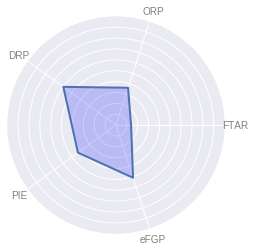

In [9]:
plot_team(get_stats(1241,categories),categories)

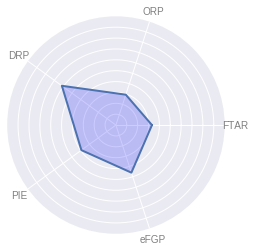

In [10]:
plot_team(get_stats(1421,categories),categories)


In [11]:
tourney.shape

(981, 61)

In [12]:
games = []

for row in tourney.to_dict('records'):
    for perspective in ['W', 'L']:
        game = {}
        game['Won'] = int(perspective == 'W')
        if perspective == 'W':
            team_letter = 'W'
            opp_letter = 'L'
        else:
            team_letter = 'L'
            opp_letter = 'W'
        winner_location = row["WLoc"]
        if winner_location == ' A':
            loser_location = 'H'
        elif winner_location == 'H':
            loser_location = 'A'
        else:
            loser_location = 'N'
        row['LLoc'] = loser_location
        team_stats = [k for k,v in row.items() if k[0] == team_letter]
        opp_stats = [k for k,v in row.items() if k[0] == opp_letter]
    #     print(team_stats)
    #     print(opp_stats)

        for stat in team_stats:
            game_stat = 'Team' + stat[1:]
            game[game_stat] = row[stat]

        for stat in opp_stats:
            opp_stat = 'Opp' + stat[1:]
            game[opp_stat] = row[stat]

        for general_stat in ['DayNum', 'NumOT', 'Season']:
            game[general_stat] = row[general_stat]

        games.append(game)
    
games

[{'DayNum': 134,
  'NumOT': 1,
  'OppAst': 16,
  'OppAstR': 14.331780723754926,
  'OppBlk': 0,
  'OppDR': 28,
  'OppDRP': 0.6666666666666666,
  'OppDefRtg': 122.01850437144554,
  'OppFGA': 67,
  'OppFGA3': 31,
  'OppFGM': 29,
  'OppFGM3': 12,
  'OppFTA': 31,
  'OppFTAR': 0.4626865671641791,
  'OppFTM': 14,
  'OppLoc': 'N',
  'OppNetRtg': -10.610304727951771,
  'OppOR': 17,
  'OppORP': 0.3617021276595745,
  'OppOffRtg': 111.40819964349377,
  'OppPF': 22,
  'OppPIE': 0.4057377049180328,
  'OppPts': 84,
  'OppRP': 0.47191011235955055,
  'OppScore': 84,
  'OppStl': 5,
  'OppTO': 15,
  'OppTOR': 13.436044428520244,
  'OppTSP': 52.083333333333336,
  'OppTeamID': 1411,
  'OppeFGP': 0.5223880597014925,
  'Season': 2003,
  'TeamAst': 17,
  'TeamAstR': 15.533625730994153,
  'TeamBlk': 3,
  'TeamDR': 30,
  'TeamDRP': 0.6382978723404256,
  'TeamDefRtg': 111.40819964349377,
  'TeamFGA': 69,
  'TeamFGA3': 29,
  'TeamFGM': 32,
  'TeamFGM3': 11,
  'TeamFTA': 26,
  'TeamFTAR': 0.37681159420289856,
  'T

In [13]:
games_df = pd.DataFrame(games)

In [14]:
games_df.shape

(1962, 62)

In [15]:
games_df.head()

DayNum  NumOT  OppAst    OppAstR  OppBlk  OppDR    OppDRP   OppDefRtg  \
0     134      1      16  14.331781       0     28  0.666667  122.018504   
1     134      1      17  15.533626       3     30  0.638298  111.408200   
2     136      0      12  12.489592       3     26  0.702703  108.761855   
3     136      0      22  19.970951       7     36  0.818182   69.335683   
4     136      0      11  10.865271       5     22  0.687500  126.885151   

   OppFGA  OppFGA3 ...   TeamPts    TeamRP  TeamScore  TeamStl  TeamTO  \
0      67       31 ...        92  0.494382         92        5      12   
1      69       29 ...        84  0.471910         84        5      15   
2      64       16 ...        80  0.580247         80       10      16   
3      66       23 ...        51  0.456790         51       10      17   
4      69       28 ...        84  0.468354         84        7       9   

     TeamTOR    TeamTSP  TeamTeamID  TeameFGP  Won  
0  10.964912  57.185480        1421  0.543478    1  
1  13.436044  52.083333        1411  0.522388    0  
2  14.524328  55.432373        1112  0.522727    1  
3  17.693589  38.014311        1436  0.343750    0  
4   9.406355  61.153174        1113  0.576271    1  

[5 rows x 62 columns]

In [16]:
season = pd.read_csv('./DataFiles/RegularSeasonDetailedResults.csv')
season.head()

Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    2003      10     1104      68     1328      62    N      0    27    58   
1    2003      10     1272      70     1393      63    N      0    26    62   
2    2003      11     1266      73     1437      61    N      0    24    58   
3    2003      11     1296      56     1457      50    N      0    18    38   
4    2003      11     1400      77     1208      71    N      0    30    61   

  ...   LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  
0 ...      10    16    22   10   22     8   18     9     2   20  
1 ...      24     9    20   20   25     7   12     8     6   16  
2 ...      26    14    23   31   22     9   12     2     5   23  
3 ...      22     8    15   17   20     9   19     4     3   23  
4 ...      16    17    27   21   15    12   10     7     1   14  

[5 rows x 34 columns]

In [17]:
#Points Winning/Losing Team
season['WPts'] = season.apply(lambda row: 2*row.WFGM + row.WFGM3 + row.WFTM, axis=1)
season['LPts'] = season.apply(lambda row: 2*row.LFGM + row.LFGM3 + row.LFTM, axis=1)

#Calculate Winning/losing Team Possesion Feature
wPos = season.apply(lambda row: 0.96*(row.WFGA + row.WTO + 0.44*row.WFTA - row.WOR), axis=1)
lPos = season.apply(lambda row: 0.96*(row.LFGA + row.LTO + 0.44*row.LFTA - row.LOR), axis=1)
#two teams use almost the same number of possessions in a game
#(plus/minus one or two - depending on how quarters end)
#so let's just take the average
season['Pos'] = (wPos+lPos)/2

In [18]:
#Offensive efficiency (OffRtg) = 100 x (Points / Possessions)
season['WOffRtg'] = season.apply(lambda row: 100 * (row.WPts / row.Pos), axis=1)
season['LOffRtg'] = season.apply(lambda row: 100 * (row.LPts / row.Pos), axis=1)

#Defensive efficiency (DefRtg) = 100 x (Opponent points / Opponent possessions)
season['WDefRtg'] = season.LOffRtg
season['LDefRtg'] = season.WOffRtg

#Net Rating = Off.Rtg - Def.Rtg
season['WNetRtg'] = season.apply(lambda row:(row.WOffRtg - row.WDefRtg), axis=1)
season['LNetRtg'] = season.apply(lambda row:(row.LOffRtg - row.LDefRtg), axis=1)
                         
#Assist Ratio : Percentage of team possessions that end in assists
season['WAstR'] = season.apply(lambda row: 100 * row.WAst / (row.WFGA + 0.44*row.WFTA + row.WAst + row.WTO), axis=1)
season['LAstR'] = season.apply(lambda row: 100 * row.LAst / (row.LFGA + 0.44*row.LFTA + row.LAst + row.LTO), axis=1)

#Turnover Ratio: Number of turnovers of a team per 100 possessions used.
#(TO * 100) / (FGA + (FTA * 0.44) + AST + TO)
season['WTOR'] = season.apply(lambda row: 100 * row.WTO / (row.WFGA + 0.44*row.WFTA + row.WAst + row.WTO), axis=1)
season['LTOR'] = season.apply(lambda row: 100 * row.LTO / (row.LFGA + 0.44*row.LFTA + row.LAst + row.LTO), axis=1)
                    
#The Shooting Percentage : Measure of Shooting Efficiency (FGA/FGA3, FTA)
season['WTSP'] = season.apply(lambda row: 100 * row.WPts / (2 * (row.WFGA + 0.44 * row.WFTA)), axis=1)
season['LTSP'] = season.apply(lambda row: 100 * row.LPts / (2 * (row.LFGA + 0.44 * row.LFTA)), axis=1)

#eFG% : Effective Field Goal Percentage adjusting for the fact that 3pt shots are more valuable 
season['WeFGP'] = season.apply(lambda row:(row.WFGM + 0.5 * row.WFGM3) / row.WFGA, axis=1)      
season['LeFGP'] = season.apply(lambda row:(row.LFGM + 0.5 * row.LFGM3) / row.LFGA, axis=1)   

#FTA Rate : How good a team is at drawing fouls.
season['WFTAR'] = season.apply(lambda row: row.WFTA / row.WFGA, axis=1)
season['LFTAR'] = season.apply(lambda row: row.LFTA / row.LFGA, axis=1)
                         
#OREB% : Percentage of team offensive rebounds
season['WORP'] = season.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
season['LORP'] = season.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)

#DREB% : Percentage of team defensive rebounds
season['WDRP'] = season.apply(lambda row: row.WDR / (row.WDR + row.LOR), axis=1)
season['LDRP'] = season.apply(lambda row: row.LDR / (row.LDR + row.WOR), axis=1)   

#REB% : Percentage of team total rebounds
season['WRP'] = season.apply(lambda row: (row.WDR + row.WOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1)
season['LRP'] = season.apply(lambda row: (row.LDR + row.WOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1) 

In [19]:
games = []

for row in season.to_dict('records'):
    for perspective in ['W', 'L']:
        game = {}
        game['Won'] = int(perspective == 'W')
        if perspective == 'W':
            team_letter = 'W'
            opp_letter = 'L'
        else:
            team_letter = 'L'
            opp_letter = 'W'
        winner_location = row["WLoc"]
        if winner_location == ' A':
            loser_location = 'H'
        elif winner_location == 'H':
            loser_location = 'A'
        else:
            loser_location = 'N'
        row['LLoc'] = loser_location
        team_stats = [k for k,v in row.items() if k[0] == team_letter]
        opp_stats = [k for k,v in row.items() if k[0] == opp_letter]
    #     print(team_stats)
    #     print(opp_stats)

        for stat in team_stats:
            game_stat = 'Team' + stat[1:]
            game[game_stat] = row[stat]

        for stat in opp_stats:
            opp_stat = 'Opp' + stat[1:]
            game[opp_stat] = row[stat]

        for general_stat in ['DayNum', 'NumOT', 'Season']:
            game[general_stat] = row[general_stat]

        games.append(game)
    
games

[{'DayNum': 10,
  'NumOT': 0,
  'OppAst': 8,
  'OppAstR': 9.021199819576003,
  'OppBlk': 2,
  'OppDR': 22,
  'OppDRP': 0.6111111111111112,
  'OppDefRtg': 97.29853479853479,
  'OppFGA': 53,
  'OppFGA3': 10,
  'OppFGM': 22,
  'OppFGM3': 2,
  'OppFTA': 22,
  'OppFTAR': 0.41509433962264153,
  'OppFTM': 16,
  'OppLoc': 'N',
  'OppNetRtg': -8.585164835164832,
  'OppOR': 10,
  'OppORP': 0.29411764705882354,
  'OppOffRtg': 88.71336996336996,
  'OppPF': 20,
  'OppPts': 62,
  'OppRP': 0.5142857142857142,
  'OppScore': 62,
  'OppStl': 9,
  'OppTO': 18,
  'OppTOR': 20.297699594046005,
  'OppTSP': 49.457562220804085,
  'OppTeamID': 1328,
  'OppeFGP': 0.4339622641509434,
  'Season': 2003,
  'TeamAst': 13,
  'TeamAstR': 12.755102040816327,
  'TeamBlk': 1,
  'TeamDR': 24,
  'TeamDRP': 0.7058823529411765,
  'TeamDefRtg': 88.71336996336996,
  'TeamFGA': 58,
  'TeamFGA3': 14,
  'TeamFGM': 27,
  'TeamFGM3': 3,
  'TeamFTA': 18,
  'TeamFTAR': 0.3103448275862069,
  'TeamFTM': 11,
  'TeamLoc': 'N',
  'TeamNet

In [20]:
season_df = pd.DataFrame(games)

In [21]:
season_df.head()

DayNum  NumOT  OppAst    OppAstR  OppBlk  OppDR    OppDRP   OppDefRtg  \
0      10      0       8   9.021200       2     22  0.611111   97.298535   
1      10      0      13  12.755102       1     24  0.705882   88.713370   
2      10      0       7   7.383966       6     25  0.625000  107.104387   
3      10      0      16  16.103060       4     28  0.583333   96.393948   
4      11      0       9   8.643872       5     22  0.564103  118.926598   

   OppFGA  OppFGA3 ...   TeamPts    TeamRP  TeamScore  TeamStl  TeamTO  \
0      53       10 ...        68  0.542857         68        7      23   
1      58       14 ...        62  0.514286         62        9      18   
2      67       24 ...        70  0.488636         70        4      13   
3      62       20 ...        63  0.454545         63        8      12   
4      73       26 ...        73  0.447917         73        5      10   

     TeamTOR    TeamTSP  TeamTeamID  TeameFGP  Won  
0  22.566719  51.577670        1104  0.491379    1  
1  20.297700  49.457562        1328  0.433962    0  
2  13.083736  49.744173        1272  0.483871    1  
3  12.658228  41.556728        1393  0.402985    0  
4  10.442774  51.582815        1266  0.482759    1  

[5 rows x 60 columns]

In [22]:
season_df.shape

(153272, 60)

In [23]:
season_df.columns

Index(['DayNum', 'NumOT', 'OppAst', 'OppAstR', 'OppBlk', 'OppDR', 'OppDRP',
       'OppDefRtg', 'OppFGA', 'OppFGA3', 'OppFGM', 'OppFGM3', 'OppFTA',
       'OppFTAR', 'OppFTM', 'OppLoc', 'OppNetRtg', 'OppOR', 'OppORP',
       'OppOffRtg', 'OppPF', 'OppPts', 'OppRP', 'OppScore', 'OppStl', 'OppTO',
       'OppTOR', 'OppTSP', 'OppTeamID', 'OppeFGP', 'Season', 'TeamAst',
       'TeamAstR', 'TeamBlk', 'TeamDR', 'TeamDRP', 'TeamDefRtg', 'TeamFGA',
       'TeamFGA3', 'TeamFGM', 'TeamFGM3', 'TeamFTA', 'TeamFTAR', 'TeamFTM',
       'TeamLoc', 'TeamNetRtg', 'TeamOR', 'TeamORP', 'TeamOffRtg', 'TeamPF',
       'TeamPts', 'TeamRP', 'TeamScore', 'TeamStl', 'TeamTO', 'TeamTOR',
       'TeamTSP', 'TeamTeamID', 'TeameFGP', 'Won'],
      dtype='object')

Train on 114954 samples, validate on 38318 samples
Epoch 1/7
114954/114954 [==============================] - 7s 64us/step - loss: 0.0493 - acc: 0.9882 - val_loss: 0.0064 - val_acc: 0.9975
Epoch 2/7
114954/114954 [==============================] - 7s 65us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 8.4291e-04 - val_acc: 0.9998
Epoch 3/7
114954/114954 [==============================] - 8s 66us/step - loss: 6.0429e-04 - acc: 0.9998 - val_loss: 2.3851e-05 - val_acc: 1.0000
Epoch 4/7
114954/114954 [==============================] - 8s 66us/step - loss: 1.1131e-05 - acc: 1.0000 - val_loss: 5.4566e-06 - val_acc: 1.0000
Epoch 5/7
114954/114954 [==============================] - 7s 65us/step - loss: 2.1137e-06 - acc: 1.0000 - val_loss: 1.0841e-06 - val_acc: 1.0000
Epoch 6/7
114954/114954 [==============================] - 8s 67us/step - loss: 8.4857e-04 - acc: 0.9998 - val_loss: 5.5083e-04 - val_acc: 0.9998
Epoch 7/7
114954/114954 [==============================] - 7s 65us/step - loss: 2.390

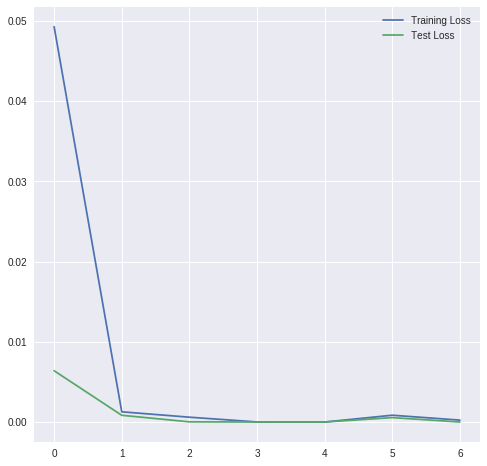

In [24]:
y = season_df.Won

X = season_df.drop(['Won', 'OppScore', 'TeamScore','TeamLoc', 'OppLoc'], axis = 1)

X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

model = Sequential()
model.add(Dense(55, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=7)

plt.figure(figsize=(8, 8))
plt.plot(hist.history['loss'], label = 'Training Loss')
plt.plot(hist.history['val_loss'], label = 'Test Loss')
plt.legend()

Train on 114954 samples, validate on 38318 samples
Epoch 1/7
114954/114954 [==============================] - 8s 70us/step - loss: 0.1398 - acc: 0.9918 - val_loss: 0.0398 - val_acc: 0.9997
Epoch 2/7
114954/114954 [==============================] - 7s 65us/step - loss: 0.0194 - acc: 0.9999 - val_loss: 0.0079 - val_acc: 1.0000
Epoch 3/7
114954/114954 [==============================] - 8s 66us/step - loss: 0.0048 - acc: 0.9998 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 4/7
114954/114954 [==============================] - 8s 69us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 4.5637e-04 - val_acc: 1.0000
Epoch 5/7
114954/114954 [==============================] - 8s 69us/step - loss: 2.4617e-04 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 0.9986
Epoch 6/7
114954/114954 [==============================] - 8s 69us/step - loss: 6.3807e-04 - acc: 0.9998 - val_loss: 1.5231e-04 - val_acc: 1.0000
Epoch 7/7
114954/114954 [==============================] - 8s 66us/step - loss: 3.2935e-04 - acc: 0.9999 

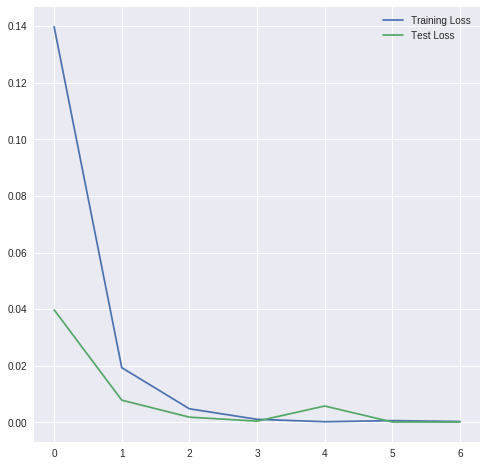

In [25]:
y = season_df.Won

X = season_df.drop(['Won', 'OppScore', 'TeamScore','TeamLoc', 'OppLoc', 'TeamTeamID', 'OppTeamID'], axis = 1)

X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

model = Sequential()
model.add(Dense(55, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=7)

plt.figure(figsize=(8, 8))
plt.plot(hist.history['loss'], label = 'Training Loss')
plt.plot(hist.history['val_loss'], label = 'Test Loss')
plt.legend()

Train on 114954 samples, validate on 38318 samples
Epoch 1/7
114954/114954 [==============================] - 8s 69us/step - loss: 0.0330 - acc: 0.9938 - val_loss: 4.6454e-04 - val_acc: 0.9999
Epoch 2/7
114954/114954 [==============================] - 8s 73us/step - loss: 5.6518e-04 - acc: 0.9999 - val_loss: 5.8123e-05 - val_acc: 1.0000
Epoch 3/7
114954/114954 [==============================] - 8s 71us/step - loss: 1.7255e-05 - acc: 1.0000 - val_loss: 1.7328e-05 - val_acc: 1.0000
Epoch 4/7
114954/114954 [==============================] - 8s 69us/step - loss: 3.1679e-06 - acc: 1.0000 - val_loss: 5.0860e-06 - val_acc: 1.0000
Epoch 5/7
114954/114954 [==============================] - 8s 71us/step - loss: 4.9855e-04 - acc: 0.9999 - val_loss: 0.0010 - val_acc: 0.9997
Epoch 6/7
114954/114954 [==============================] - 8s 71us/step - loss: 2.1772e-04 - acc: 0.9999 - val_loss: 6.1288e-05 - val_acc: 0.9999
Epoch 7/7
114954/114954 [==============================] - 8s 69us/step - loss: 4

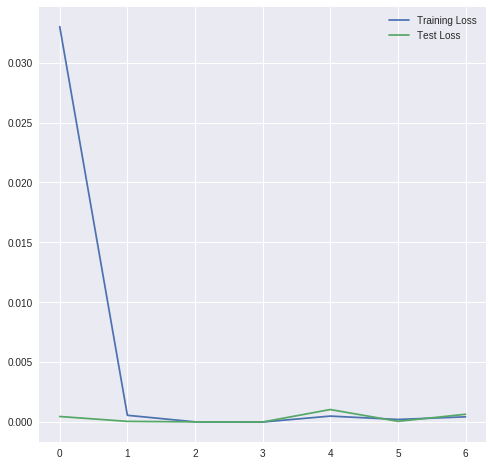

In [26]:
y = season_df.Won

X = season_df.drop(['Won', 'OppScore', 'TeamScore','TeamLoc', 'OppLoc', 'TeamTeamID', 'OppTeamID', 'TeamPts', 'OppPts'], axis = 1)

X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

model = Sequential()
model.add(Dense(55, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=7)

plt.figure(figsize=(8, 8))
plt.plot(hist.history['loss'], label = 'Training Loss')
plt.plot(hist.history['val_loss'], label = 'Test Loss')
plt.legend()

In [27]:
X_train.columns

Index(['DayNum', 'NumOT', 'OppAst', 'OppAstR', 'OppBlk', 'OppDR', 'OppDRP',
       'OppDefRtg', 'OppFGA', 'OppFGA3', 'OppFGM', 'OppFGM3', 'OppFTA',
       'OppFTAR', 'OppFTM', 'OppNetRtg', 'OppOR', 'OppORP', 'OppOffRtg',
       'OppPF', 'OppRP', 'OppStl', 'OppTO', 'OppTOR', 'OppTSP', 'OppeFGP',
       'Season', 'TeamAst', 'TeamAstR', 'TeamBlk', 'TeamDR', 'TeamDRP',
       'TeamDefRtg', 'TeamFGA', 'TeamFGA3', 'TeamFGM', 'TeamFGM3', 'TeamFTA',
       'TeamFTAR', 'TeamFTM', 'TeamNetRtg', 'TeamOR', 'TeamORP', 'TeamOffRtg',
       'TeamPF', 'TeamRP', 'TeamStl', 'TeamTO', 'TeamTOR', 'TeamTSP',
       'TeameFGP'],
      dtype='object')

In [28]:
preds= model.predict_proba(X_test_scaled)

In [30]:
#look at decision trees. 

In [32]:
bag = BaggingClassifier()
bag_params = {
    
    'n_estimators': [5,10,15,20,25,30],
    'max_samples': [.25, .50, .75, 1.0],
    'max_features': [.25, .50, .75],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'random_state': [None, 42]
}
gs_bag = GridSearchCV(bag, bag_params)
gs_bag.fit(X_train, y_train)
print(gs_bag.best_score_)
print(gs_bag.best_params_)

1.0
{'bootstrap': True, 'bootstrap_features': True, 'max_features': 0.25, 'max_samples': 0.25, 'n_estimators': 15, 'random_state': 42}


In [33]:
rf = RandomForestClassifier(random_state=42)
rf_params = {
    
    'n_estimators': [5,10,15,20,25],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'max_features': ['auto', 'sqrt', 'log2', None]
}
gs_rf  = GridSearchCV(rf, rf_params)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)
print(gs_rf.best_params_)

1.0
{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 5}


In [34]:
ada = AdaBoostClassifier(random_state=42)
ada_params = {
    
    'n_estimators': [40,50,60]
}
gs_ada = GridSearchCV(ada, ada_params)
gs_ada.fit(X_train, y_train)
print(gs_ada.best_score_)
print(gs_ada.best_params_)

1.0
{'n_estimators': 40}


In [35]:
gb = GradientBoostingClassifier()
gb_params= {
    'max_depth': [2,3,4],
    'n_estimators': [50,100,150, 200],
    'max_features': ['sqrt', 'log2', None]
}
gs_gb = GridSearchCV(gb, gb_params)
gs_gb.fit(X_train, y_train)
print(gs_gb.best_score_)
print(gs_gb.best_params_)

1.0
{'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 50}


In [38]:
X.columns

Index(['DayNum', 'NumOT', 'OppAst', 'OppAstR', 'OppBlk', 'OppDR', 'OppDRP',
       'OppDefRtg', 'OppFGA', 'OppFGA3', 'OppFGM', 'OppFGM3', 'OppFTA',
       'OppFTAR', 'OppFTM', 'OppNetRtg', 'OppOR', 'OppORP', 'OppOffRtg',
       'OppPF', 'OppRP', 'OppStl', 'OppTO', 'OppTOR', 'OppTSP', 'OppeFGP',
       'Season', 'TeamAst', 'TeamAstR', 'TeamBlk', 'TeamDR', 'TeamDRP',
       'TeamDefRtg', 'TeamFGA', 'TeamFGA3', 'TeamFGM', 'TeamFGM3', 'TeamFTA',
       'TeamFTAR', 'TeamFTM', 'TeamNetRtg', 'TeamOR', 'TeamORP', 'TeamOffRtg',
       'TeamPF', 'TeamRP', 'TeamStl', 'TeamTO', 'TeamTOR', 'TeamTSP',
       'TeameFGP'],
      dtype='object')

Train on 114954 samples, validate on 38318 samples
Epoch 1/7
114954/114954 [==============================] - 8s 72us/step - loss: 0.0141 - acc: 0.9968 - val_loss: 2.4001e-04 - val_acc: 1.0000
Epoch 2/7
114954/114954 [==============================] - 7s 63us/step - loss: 1.0731e-04 - acc: 1.0000 - val_loss: 2.2342e-05 - val_acc: 1.0000
Epoch 3/7
114954/114954 [==============================] - 7s 64us/step - loss: 2.6901e-04 - acc: 0.9999 - val_loss: 7.1036e-05 - val_acc: 1.0000
Epoch 4/7
114954/114954 [==============================] - 7s 65us/step - loss: 1.4092e-05 - acc: 1.0000 - val_loss: 1.4495e-06 - val_acc: 1.0000
Epoch 5/7
114954/114954 [==============================] - 7s 64us/step - loss: 1.0682e-06 - acc: 1.0000 - val_loss: 5.2130e-07 - val_acc: 1.0000
Epoch 6/7
114954/114954 [==============================] - 8s 68us/step - loss: 3.9756e-07 - acc: 1.0000 - val_loss: 2.4973e-07 - val_acc: 1.0000
Epoch 7/7
114954/114954 [==============================] - 7s 64us/step - los

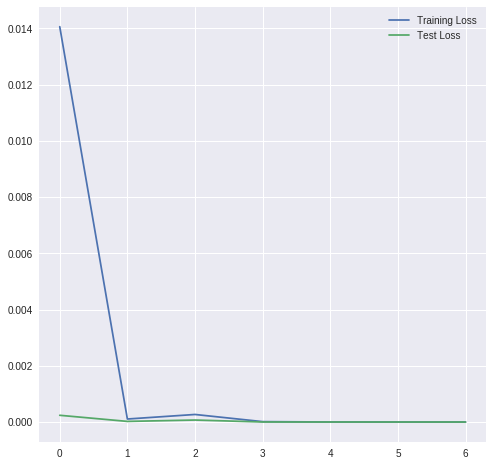

In [40]:
y = season_df.Won


features = ['TeamOffRtg', 'OppOffRtg', 'TeamDefRtg', 'OppDefRtg', 'TeamNetRtg', 'OppNetRtg', 'TeamAstR', 'OppAstR',\
           'TeamTOR', 'OppTOR', 'TeamTSP', 'OppTSP', 'TeameFGP', 'OppeFGP', 'TeamFTAR', 'OppFTAR', 'TeamORP', 'OppORP',\
           'TeamDRP', 'OppDRP', 'TeamRP', 'OppRP']

X = season_df[features]

X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

model = Sequential()
model.add(Dense(55, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=7)

plt.figure(figsize=(8, 8))
plt.plot(hist.history['loss'], label = 'Training Loss')
plt.plot(hist.history['val_loss'], label = 'Test Loss')
plt.legend()
